# Purpose
- goal is to use DLC-estimated key points and define behavioral epochs
- data is from Alex F from Knowles lab, and we want to quanitfy:

1. time in light box (time visible)
    - nose only
    - nose and ears
    - nose and ears and butt
2. distance to edge IN REAL COORDINATES
    - adjust marked coordinates to real coordinates (50cm2 box)
    - get animal position relative to corners
3. #, timing, location of rearing events
4. #, timing, location of jumps


# imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from scipy.io import arff
import math

In [4]:
import itertools

# functions

In [5]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                for idx in np.arange(0,len(part.x)):
                    second_idx = np.max([0,idx-1])
                    if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                        part.y[idx] = np.nan
                    elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                        part.x[idx] = np.nan
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x = part.x.interpolate()
                part.x=part.x.rolling(seconds*fps,min_periods=1).median()
                part.y = part.y.interpolate()
                part.y=part.y.rolling(seconds*fps,min_periods=1).median()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [6]:
def align_df(df):
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# load an example file, preprocess data (exclude outliers, smooth)

In [8]:
filename = "/Users/dennise/Downloads/40DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
#filename = "/home/dennislab2/Desktop/videos/skok_alex_videos/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000.csv"
df = pd.read_csv(filename,header=[1,2])
df

bodyparts      box_tl                              box_tr              \
         coords           x           y likelihood            x           y   
0             0  608.890930  137.177429   0.999937  1435.935181  133.449844   
1             1  609.026184  137.228836   0.999944  1435.722290  133.298462   
2             2  608.952393  137.127045   0.999947  1435.255493  133.910370   
3             3  608.727783  137.290833   0.999926  1435.532104  133.315872   
4             4  608.264832  137.235138   0.999911  1435.757568  133.399460   
...         ...         ...         ...        ...          ...         ...   
17964     17964  503.502930   82.453690   0.999946  1340.407715   93.316391   
17965     17965  503.584198   82.293343   0.999946  1340.825317   92.820450   
17966     17966  503.571899   82.211983   0.999939  1340.948486   92.944283   
17967     17967  503.899475   82.274933   0.999948  1340.306396   93.943207   
17968     17968  503.283875   82.061783   0.999954  1340.055298   93.776512   

                      box_bl                         ... paw_left_front  \
      likelihood           x           y likelihood  ...     likelihood   
0       0.999885  621.989075  964.835571   0.999682  ...       0.002223   
1       0.999894  621.874146  964.738464   0.999597  ...       0.002217   
2       0.999934  621.602905  964.921631   0.999493  ...       0.002338   
3       0.999907  620.326782  963.349243   0.999349  ...       0.002410   
4       0.999907  620.892883  963.570862   0.999385  ...       0.002459   
...          ...         ...         ...        ...  ...            ...   
17964   0.998927  528.834412  927.547302   0.999713  ...       0.819929   
17965   0.999003  528.671570  927.529053   0.999745  ...       0.737095   
17966   0.999041  529.751648  927.617371   0.999626  ...       0.682940   
17967   0.999096  528.878662  928.079468   0.999739  ...       0.727277   
17968   0.999223  528.931091  928.021362   0.999814  ...       0.744086   

      paw_right_front                        paw_left_back              \
                    x           y likelihood             x           y   
0          616.298584  614.605957   0.001432   1440.091431  948.997620   
1         1446.195190  939.367004   0.001931   1440.168091  948.649170   
2         1445.983643  939.355347   0.002285   1440.114990  948.615723   
3         1445.832275  939.185669   0.001849   1439.597778  948.306824   
4         1446.194092  938.934937   0.001860   1439.716431  948.152893   
...               ...         ...        ...           ...         ...   
17964     1027.021606  871.674744   0.129225   1046.870850  798.244080   
17965     1032.811890  871.734497   0.127350   1046.712158  798.124939   
17966     1039.200439  872.923340   0.204688   1046.419556  798.082031   
17967     1043.548828  876.429382   0.199354   1044.383789  792.670776   
17968     1053.473267  878.735107   0.182177   1046.122437  798.144897   

                 paw_right_back                         
      likelihood              x           y likelihood  
0       0.003244    1439.282959  139.766632   0.011671  
1       0.002401    1439.048706  139.711456   0.011051  
2       0.002745    1439.146973  139.889023   0.014622  
3       0.002315    1439.411743  139.700668   0.013699  
4       0.002888    1439.465332  139.785385   0.012330  
...          ...            ...         ...        ...  
17964   0.276916    1007.209290  855.448059   0.584535  
17965   0.265509    1007.957703  856.564758   0.752716  
17966   0.254741    1008.819275  856.685059   0.822648  
17967   0.293373    1010.391113  856.477783   0.923445  
17968   0.353675    1013.887512  857.831787   0.922712  

[17969 rows x 46 columns]

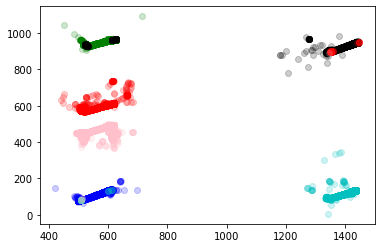

In [9]:
a=0
b=-1
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.2)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.2)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.2)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.2)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.2)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.2)
plt.show()

## which rolling window is "good" at discarding random jumps in assignment but still capturing the slides?

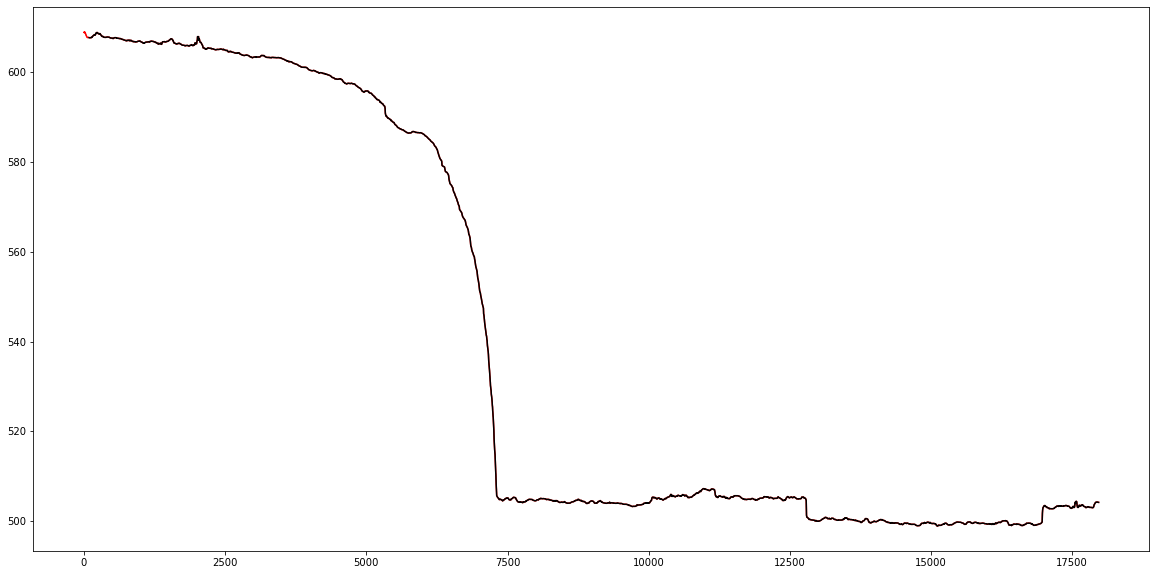

In [10]:
s = df.box_tl["x"]
seconds=3
fps=30
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps,min_periods=1).median(),c='r')
plt.plot(s.rolling(seconds*fps).median(),c='k')
#plt.xlim((0,100))
plt.show()

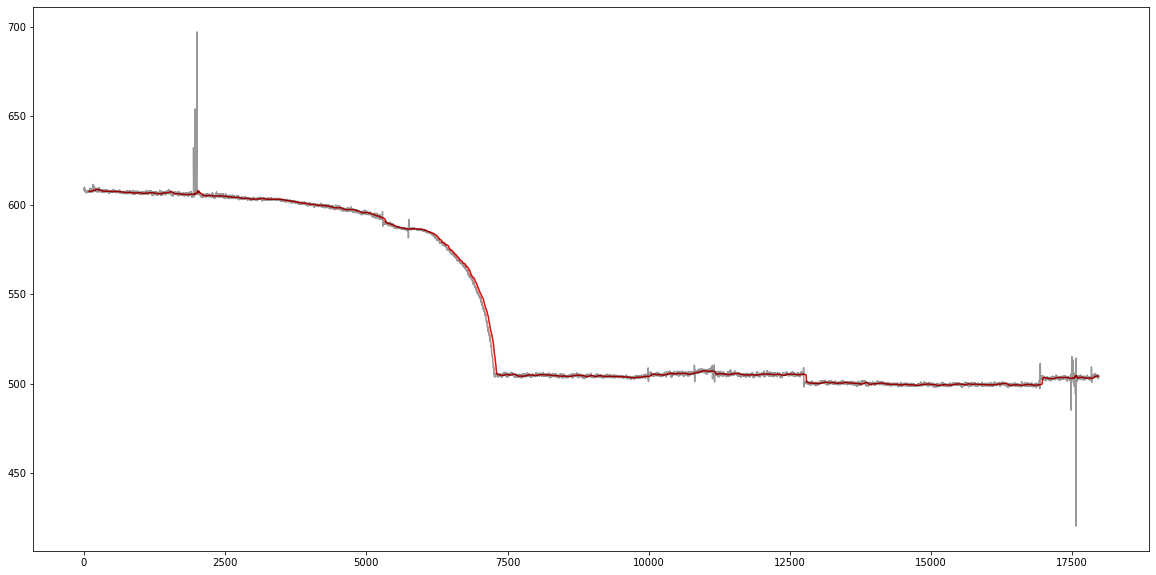

In [11]:
s = df.box_tl["x"]
plt.figure(figsize=(20,10))
plt.plot(s.rolling(seconds*fps).median(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.show()

### what adjustments do we need for body parts?

In [13]:
new_df=reformat_df(df,0.9,1000,15,3,30)

C:\Users\dennise\AppData\Local\Temp\ipykernel_18924\3168813908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df=reformat_df(df,0.9,1000,15,3,30)
C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
new_df

box_bl                              box_br                         \
                x           y likelihood            x           y likelihood   
0      621.989075  964.835571   0.999682  1441.310913  949.574219   0.999924   
1      621.931610  964.787018   0.999597  1441.295837  949.187195   0.999915   
2      621.874146  964.835571   0.999493  1441.280762  948.812988   0.999867   
3      621.738525  964.787018   0.999349  1440.973511  948.806580   0.999889   
4      621.602905  964.738464   0.999385  1441.280762  948.800171   0.999921   
...           ...         ...        ...          ...         ...        ...   
17964  528.772278  929.584198   0.999713  1339.348328  895.287842   0.999569   
17965  528.772278  929.561859   0.999745  1339.348328  895.269806   0.999388   
17966  528.809875  929.505096   0.999626  1339.348328  895.269806   0.999576   
17967  528.829773  929.433411   0.999739  1339.348328  895.269806   0.999666   
17968  528.856537  929.368225   0.999814  1339.339844  895.245514   0.999504   

           box_tl                              box_tr  ... paw_right_back  \
                x           y likelihood            x  ...     likelihood   
0      608.890930  137.177429   0.999937  1435.935181  ...       0.011671   
1      608.958557  137.203133   0.999944  1435.828735  ...       0.011051   
2      608.952393  137.177429   0.999947  1435.722290  ...       0.014622   
3      608.921661  137.203133   0.999926  1435.627197  ...       0.013699   
4      608.890930  137.228836   0.999911  1435.722290  ...       0.012330   
...           ...         ...        ...          ...  ...            ...   
17964  504.192780   82.648014   0.999946  1340.828369  ...       0.584535   
17965  504.192780   82.640594   0.999946  1340.837585  ...       0.752716   
17966  504.192780   82.629124   0.999939  1340.856934  ...       0.822648   
17967  504.192780   82.615185   0.999948  1340.856934  ...       0.923445   
17968  504.192780   82.606331   0.999954  1340.856934  ...       0.922712   

      paw_right_front                           tail_base              \
                    x           y likelihood            x           y   
0                 NaN         NaN   0.001432          NaN         NaN   
1                 NaN         NaN   0.001931          NaN         NaN   
2                 NaN         NaN   0.002285          NaN         NaN   
3                 NaN         NaN   0.001849          NaN         NaN   
4                 NaN         NaN   0.001860          NaN         NaN   
...               ...         ...        ...          ...         ...   
17964      994.059204  902.827271   0.129225  1011.953796  807.225952   
17965      994.059204  902.827271   0.127350  1011.803589  807.693481   
17966      994.059204  902.827271   0.204688  1011.684753  808.058167   
17967      994.059204  902.827271   0.199354  1010.845154  809.716797   
17968      994.059204  902.827271   0.182177  1012.374634  810.364563   

                 tail_tip                 
      likelihood        x   y likelihood  
0       0.011147      NaN NaN   0.038663  
1       0.016146      NaN NaN   0.033272  
2       0.015772      NaN NaN   0.035207  
3       0.016750      NaN NaN   0.029825  
4       0.020325      NaN NaN   0.038245  
...          ...      ...  ..        ...  
17964   0.993937      NaN NaN   0.016658  
17965   0.993945      NaN NaN   0.018624  
17966   0.993939      NaN NaN   0.013779  
17967   0.996211      NaN NaN   0.082493  
17968   0.998378      NaN NaN   0.119596  

[17969 rows x 45 columns]

In [15]:
#filename[:-4]+"_adj.csv"
new_df.to_csv(filename[:-4]+"_adj.csv")

In [12]:
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)

In [13]:
new_df

box_bl                               box_br               \
                x            y likelihood            x            y   
0      599.930908   963.720642   0.999816  1414.975220   962.655518   
1      600.101990   963.641968   0.999885  1415.067139   962.684021   
2      599.930908   963.563293   0.999852  1414.975220   962.655518   
3      599.848785   963.641968   0.999783  1415.067139   962.684021   
4      599.930908   963.613708   0.999855  1415.159058   962.712524   
...           ...          ...        ...          ...          ...   
17969  692.759766  1005.954803   0.999672  1531.512146  1018.393829   
17970  692.759766  1005.954803   0.999625  1531.512146  1018.393829   
17971  692.759766  1005.954803   0.999730  1531.512146  1018.385437   
17972  692.759766  1005.954803   0.999734  1531.512146  1018.385437   
17973  692.770569  1005.931671   0.999609  1531.512146  1018.385437   

                      box_tl                              box_tr  ...  \
      likelihood           x           y likelihood            x  ...   
0       0.999792  600.575623  141.166534   0.999926  1417.813110  ...   
1       0.999763  600.614746  141.452858   0.999920  1417.661743  ...   
2       0.999830  600.653870  141.739182   0.999900  1417.739380  ...   
3       0.999784  600.682068  141.801613   0.999923  1417.624878  ...   
4       0.999807  600.710266  141.864044   0.999883  1417.510376  ...   
...          ...         ...         ...        ...          ...  ...   
17969   0.997551  698.265045  189.274338   0.999886  1519.408508  ...   
17970   0.997794  698.271545  189.278542   0.999876  1519.408508  ...   
17971   0.998031  698.275543  189.281776   0.999853  1519.408508  ...   
17972   0.997953  698.275543  189.281776   0.999842  1519.403564  ...   
17973   0.998206  698.275543  189.281776   0.999882  1519.403564  ...   

      paw_right_back paw_right_front                  tail_base              \
          likelihood               x   y likelihood           x           y   
0           0.006150             NaN NaN   0.003026         NaN         NaN   
1           0.006930             NaN NaN   0.002901         NaN         NaN   
2           0.007855             NaN NaN   0.003280         NaN         NaN   
3           0.006398             NaN NaN   0.004063         NaN         NaN   
4           0.006106             NaN NaN   0.003776         NaN         NaN   
...              ...             ...  ..        ...         ...         ...   
17969       0.954382             NaN NaN   0.770925  911.676392  393.177826   
17970       0.952148             NaN NaN   0.808792  911.796021  393.423065   
17971       0.864063             NaN NaN   0.822342  912.262878  392.658478   
17972       0.463479             NaN NaN   0.740434  912.982849  390.989838   
17973       0.439683             NaN NaN   0.542728  914.530090  386.379028   

                    tail_tip                         
      likelihood           x           y likelihood  
0       0.008742         NaN         NaN   0.008444  
1       0.008749         NaN         NaN   0.010901  
2       0.008887         NaN         NaN   0.010367  
3       0.009111         NaN         NaN   0.014907  
4       0.008729         NaN         NaN   0.011806  
...          ...         ...         ...        ...  
17969   0.999731  821.305176  487.758423   0.997880  
17970   0.999720  821.612976  487.403870   0.998094  
17971   0.999845  821.693970  487.485687   0.997955  
17972   0.999910  822.745972  486.795990   0.997914  
17973   0.999966  826.346802  484.334503   0.998515  

[17974 rows x 45 columns]

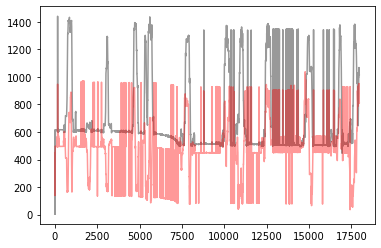

In [16]:
#plt.figure(figsize=(20,10))
plt.plot(part.x,c='k',alpha=0.4)
plt.plot(part.y,c='r',alpha=.4)
plt.show()

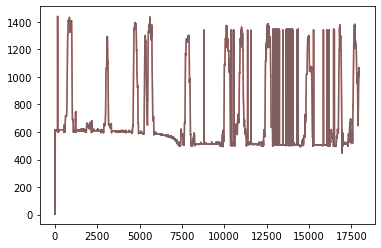

In [17]:
#plt.figure(figsize=(20,10))
#plt.plot(part.y,c='k')
plt.plot(part.x.interpolate(limit=15),c='r',alpha=1)
plt.plot(part.x.interpolate(limit=5),c='c',alpha=0.5)
plt.show()

# preprocessing thoughts 

let's say for now,
- for corners, rolling median of 90 (frames, 3 sec)
- interpolating between nans limit = 15 (.5 sec)

### ~TODO~ Done:
1. first, apply the above lessons to an entire dataframe, save it
2. should make box, and find region (in px) that correspond to 5 cm from edge (of the 50x50cm box)
3. extract useful info
    a. how much time did the animal spend visible?
        i. just nose?
        ii. nose + ears?
        iii. nose + ears + tail base?

## affine transform of points to correct for sliding FOV

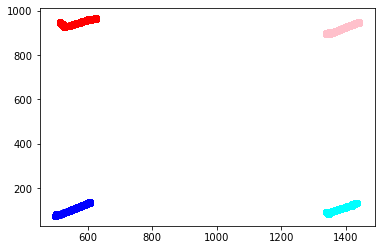

In [18]:
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='r') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='pink') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='cyan') #500,0mm

In [19]:
s1=[0,500]
s2=[500,500]
s3=[0,0]
s4=[500,0]
idx=1000
p1=[new_df.box_bl.x[idx],new_df.box_bl.y[idx]] #0,500
p2=[new_df.box_br.x[idx],new_df.box_br.y[idx]] #500,500
p3=[new_df.box_tl.x[idx],new_df.box_tl.y[idx]] #0,0
p4=[new_df.box_tr.x[idx],new_df.box_tr.y[idx]] #500,0
print(p1,p2,p3,p4)
print(s1,s2,s3,s4)

[622.4177551269531, 964.8092956542969] [1438.9189453125, 947.7817993164062] [606.8510131835938, 138.08313751220703] [1432.754638671875, 133.22383880615234]
[0, 500] [500, 500] [0, 0] [500, 0]


In [21]:
# get a transform matrix
A2 = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))

# set points
pts = np.array([[p1]],dtype='float32')

# use transform matrix to un-warp the points
cv2.perspectiveTransform(pts,A2)

array([[[-5.823127e-14,  5.000000e+02]]], dtype=float32)

In [ ]:
aligned_df=align_df(new_df)
aligned_df

at 0 of 17969 rows
at 1000 of 17969 rows
at 2000 of 17969 rows
at 3000 of 17969 rows


### let's see what the data look like after adjustment

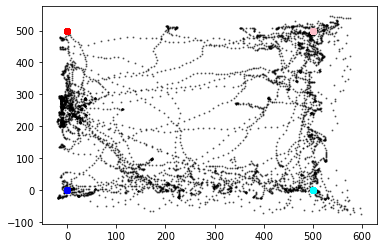

In [425]:
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.show()

In [426]:
nose_df = aligned_df.nose
nose_df

,x,y,likelihood
0,NaN,NaN,0.006743
1,NaN,NaN,0.007441
2,NaN,NaN,0.006668
3,NaN,NaN,0.007078
4,NaN,NaN,0.007489
...,...,...,...
17969,125.928253,71.330910,0.993589
17970,119.967941,70.642426,0.990155
17971,113.646049,69.631096,0.997681
17972,106.418182,69.043922,0.998823


### how much time did the animal spend in the box?


In [23]:
aligned_df = pd.read_csv('/Users/dennise/Downloads/5DLC_resnet50_2022_Knowles_AlexOct13shuffle1_500000_aligned.csv', index_col=0, header=[0,1])

In [25]:
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

print("frames with nose: {}".format(np.sum(nose_vals)))
frames_with_nose = np.sum(nose_vals)
print("frames with nose and ears: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals)))
print("frames with nose and ears and tail: {}".format(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals)))
print("total frames {}".format(len(nose_vals)))

frames with nose: 5538
frames with nose and ears: 5314
frames with nose and ears and tail: 5044
total frames 17974


C:\Users\dennise\Anaconda3\envs\fieldwork_2021\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


### how much time did it spend within 50mm of the 500mm^2 walls?


In [29]:
# can just use adj px values > 450 and < 50 (further vals are outside walls, but include jumps and rears which we do want to include)
nose_df=aligned_df[~np.isnan(aligned_df.nose.x)]
nose_df['within50mm']=0
for idx in nose_df.index:
    xval=nose_df.x[idx]
    yval=nose_df.y[idx]
    if xval < 50 or xval > 450 or yval < 50 or yval > 450:
        nose_df.iloc[idx,3]=1
summed_val=np.sum(nose_df.within50mm)
print("frames with nose within 50mm of edge {}".format(summed_val))
print("fraction of frames where animal is inside the box AND within 50mm of an edge {}".format(summed_val/frames_with_nose))
print("fraction of frames where animal is inside and in the center (further than 50mm from an edge): {}".format((frames_with_nose-summed_val)/frames_with_nose))

C:\Users\dennise\AppData\Local\Temp\ipykernel_5792\2549802310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0


AttributeError: 'DataFrame' object has no attribute 'x'

In [411]:
print(5538/17973)
print(17973/29.93)

0.30812885995660155
600.5011693952556


### find first frame where it enters the 'center' of the box

In [412]:
tstdf=nose_df[~np.isnan(nose_df.x)]
tstdf=tstdf[tstdf.within50mm<1]
print("first frame in center (> 50mm from edge): {}".format(tstdf.index[0]))

first frame in center (> 50mm from edge): 946


In [413]:
# plot points in adjusted space

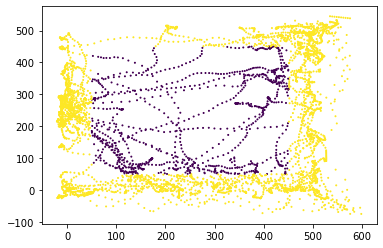

In [414]:
plt.scatter(nose_df.x,nose_df.y,c=nose_df.within50mm,s=1)

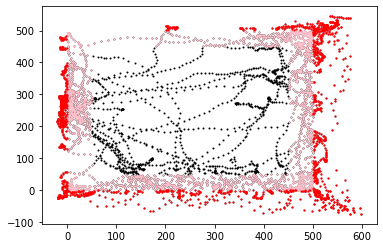

In [415]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)

plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)

### save out aligned data

In [416]:
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

## jump and rear classifications

In [145]:
Alex_annot_filename = '/Users/dennise/Desktop/boris_events_5.csv'
annots=pd.read_csv(Alex_annot_filename,skiprows=14,header=1)
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",header=[0,1],index_col=0)
print(annots.head())
aligned_df.head()

     Time                                    Media file path  Total length  \
0  19.473  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
1  19.972  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
2  22.472  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
3  22.722  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   
4  33.472  C:/Users/WinAdm/OneDrive - Nexus365/Postdoc/Pr...        737.18   

     FPS  Subject Behavior  Behavioral category  Comment Status  
0  29.93      NaN    Light                  NaN      NaN  START  
1  29.93      NaN   Moving                  NaN      NaN  START  
2  29.93      NaN   Moving                  NaN      NaN   STOP  
3  29.93      NaN    Light                  NaN      NaN   STOP  
4  29.93      NaN    Light                  NaN      NaN  START  


box_bl                   box_br                          box_tl  \
              x      y likelihood      x      y likelihood             x   
0  0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1 -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2  0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3  1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4  0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   

                           box_tr  ... paw_right_back paw_right_front      \
              y likelihood      x  ...     likelihood               x   y   
0  0.000000e+00   0.999926  500.0  ...       0.006150             NaN NaN   
1 -1.428753e-14   0.999920  500.0  ...       0.006930             NaN NaN   
2  0.000000e+00   0.999900  500.0  ...       0.007855             NaN NaN   
3  0.000000e+00   0.999923  500.0  ...       0.006398             NaN NaN   
4 -2.856428e-14   0.999883  500.0  ...       0.006106             NaN NaN   

             tail_base                tail_tip                 
  likelihood         x   y likelihood        x   y likelihood  
0   0.003026       NaN NaN   0.008742      NaN NaN   0.008444  
1   0.002901       NaN NaN   0.008749      NaN NaN   0.010901  
2   0.003280       NaN NaN   0.008887      NaN NaN   0.010367  
3   0.004063       NaN NaN   0.009111      NaN NaN   0.014907  
4   0.003776       NaN NaN   0.008729      NaN NaN   0.011806  

[5 rows x 45 columns]

In [146]:
# looks like Alex's annots are 2s off a bit. need to align them with our frames.

### first predicted entry

In [147]:
first_predicted=aligned_df[aligned_df.nose.x>-100].index[0]
first_annotated = annots.Time[0]
print("first frame with predicted entry {}".format(first_predicted))
print("first annotated entry {}".format(first_predicted))
print("first annotated entry * FPS {}".format(first_annotated*annots.FPS[0]))
print("offset in frames {}".format(first_annotated*annots.FPS[0]-first_predicted))
offset = first_annotated-(first_predicted/annots.FPS[0])
print("offset in seconds {}".format(offset))
annots['adj_time']=annots.Time-offset
annots['adj_frame']=annots.adj_time*annots.FPS

first frame with predicted entry 517
first annotated entry 517
first annotated entry * FPS 582.8268899999999
offset in frames 65.82688999999993
offset in seconds 2.1993615101904425


In [148]:
aligned_df['in_box']=float(0)
for idx in aligned_df.index:
    if np.isnan(aligned_df.nose.x[idx]):
        aligned_df.iloc[idx,-1]=0
    else:
        aligned_df.iloc[idx,-1]=1

In [149]:
annots_in_box=annots[annots.Behavior=='Light'].reset_index()
aligned_df['annots','in_light']=float(0)
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... paw_right_front             \
                  y likelihood      x  ...               y likelihood   
0      0.000000e+00   0.999926  500.0  ...             NaN   0.003026   
1     -1.428753e-14   0.999920  500.0  ...             NaN   0.002901   
2      0.000000e+00   0.999900  500.0  ...             NaN   0.003280   
3      0.000000e+00   0.999923  500.0  ...             NaN   0.004063   
4     -2.856428e-14   0.999883  500.0  ...             NaN   0.003776   
...             ...        ...    ...  ...             ...        ...   
17969  0.000000e+00   0.999886  500.0  ...             NaN   0.770925   
17970 -2.758458e-14   0.999876  500.0  ...             NaN   0.808792   
17971  0.000000e+00   0.999853  500.0  ...             NaN   0.822342   
17972  0.000000e+00   0.999842  500.0  ...             NaN   0.740434   
17973  0.000000e+00   0.999882  500.0  ...             NaN   0.542728   

        tail_base                          tail_tip                         \
                x           y likelihood          x           y likelihood   
0             NaN         NaN   0.008742        NaN         NaN   0.008444   
1             NaN         NaN   0.008749        NaN         NaN   0.010901   
2             NaN         NaN   0.008887        NaN         NaN   0.010367   
3             NaN         NaN   0.009111        NaN         NaN   0.014907   
4             NaN         NaN   0.008729        NaN         NaN   0.011806   
...           ...         ...        ...        ...         ...        ...   
17969  132.831360  127.650238   0.999731  77.391563  185.406219   0.997880   
17970  132.903915  127.801270   0.999720  77.579056  185.189346   0.998094   
17971  133.188095  127.333473   0.999845  77.627518  185.239502   0.997955   
17972  133.631027  126.314026   0.999910  78.275650  184.820328   0.997914   
17973  134.578949  123.490120   0.999966  80.488739  183.321564   0.998515   

      in_box   annots  
             in_light  
0        0.0      0.0  
1        0.0      0.0  
2        0.0      0.0  
3        0.0      0.0  
4        0.0      0.0  
...      ...      ...  
17969    1.0      0.0  
17970    1.0      0.0  
17971    1.0      0.0  
17972    1.0      0.0  
17973    1.0      0.0  

[17974 rows x 47 columns]

In [150]:
fps=annots.FPS[0]
aligned_df['annots','in_light']=0

for idx in np.arange(0,len(annots_in_box),2):
    print(annots_in_box.Time[idx])
    val1=int(round(annots_in_box.adj_frame[idx]))
    val2=int(round(annots_in_box.adj_frame[idx+1]))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

19.473
33.472
70.971
102.221
144.532
161.282
190.9
230.994
320.462
415.446
464.062
599.65


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... paw_right_front             \
                  y likelihood      x  ...               y likelihood   
0      0.000000e+00   0.999926  500.0  ...             NaN   0.003026   
1     -1.428753e-14   0.999920  500.0  ...             NaN   0.002901   
2      0.000000e+00   0.999900  500.0  ...             NaN   0.003280   
3      0.000000e+00   0.999923  500.0  ...             NaN   0.004063   
4     -2.856428e-14   0.999883  500.0  ...             NaN   0.003776   
...             ...        ...    ...  ...             ...        ...   
17969  0.000000e+00   0.999886  500.0  ...             NaN   0.770925   
17970 -2.758458e-14   0.999876  500.0  ...             NaN   0.808792   
17971  0.000000e+00   0.999853  500.0  ...             NaN   0.822342   
17972  0.000000e+00   0.999842  500.0  ...             NaN   0.740434   
17973  0.000000e+00   0.999882  500.0  ...             NaN   0.542728   

        tail_base                          tail_tip                         \
                x           y likelihood          x           y likelihood   
0             NaN         NaN   0.008742        NaN         NaN   0.008444   
1             NaN         NaN   0.008749        NaN         NaN   0.010901   
2             NaN         NaN   0.008887        NaN         NaN   0.010367   
3             NaN         NaN   0.009111        NaN         NaN   0.014907   
4             NaN         NaN   0.008729        NaN         NaN   0.011806   
...           ...         ...        ...        ...         ...        ...   
17969  132.831360  127.650238   0.999731  77.391563  185.406219   0.997880   
17970  132.903915  127.801270   0.999720  77.579056  185.189346   0.998094   
17971  133.188095  127.333473   0.999845  77.627518  185.239502   0.997955   
17972  133.631027  126.314026   0.999910  78.275650  184.820328   0.997914   
17973  134.578949  123.490120   0.999966  80.488739  183.321564   0.998515   

      in_box   annots  
             in_light  
0        0.0        0  
1        0.0        0  
2        0.0        0  
3        0.0        0  
4        0.0        0  
...      ...      ...  
17969    1.0        0  
17970    1.0        0  
17971    1.0        0  
17972    1.0        0  
17973    1.0        0  

[17974 rows x 47 columns]

### plot the should-be-aligned data

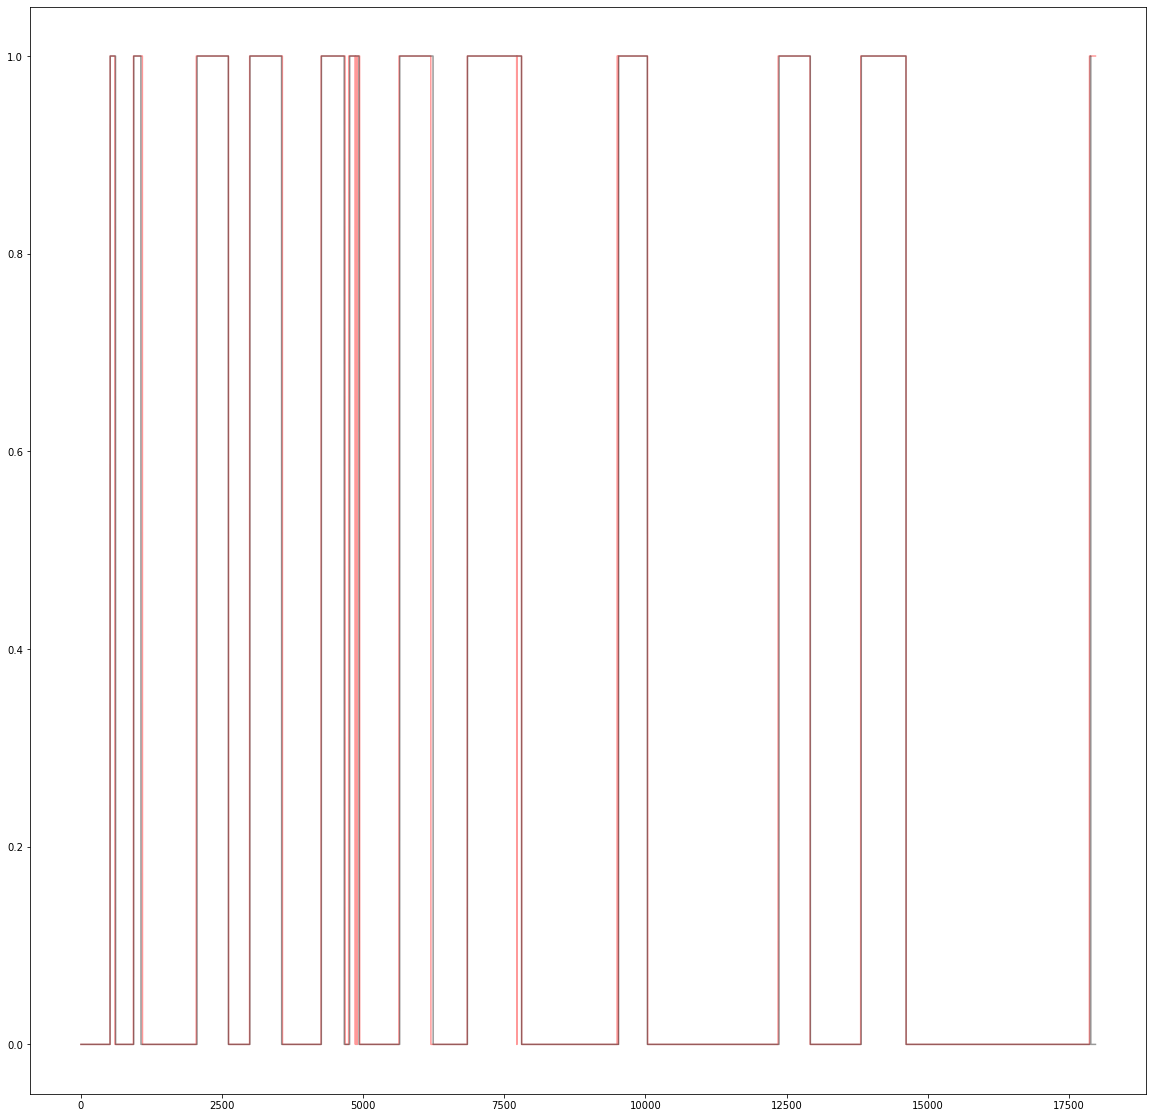

In [151]:
start=400
inc=400
plt.figure(figsize=(20,20))
plt.plot(aligned_df.in_box,'r',alpha=.4)
plt.plot(aligned_df.annots.in_light,'k',alpha=.4)
#plt.xlim([start,start+inc])

## building a classifier, random forest

### rears

In [152]:
annots_rears=pd.DataFrame()

for idx in annots.index:
    if "rear" in annots.Behavior[idx]:
        annots_rears=pd.concat([annots_rears,annots[annots.index==idx]],axis=0)

annots_rears=annots_rears.reset_index().drop(columns='index')

In [153]:
## add anns to df
aligned_df['annots','rear_supported']=float(0)
aligned_df['annots','rear_unsupported']=float(0)

In [154]:
for idx in np.arange(0,len(annots_rears),2):
    val1=int(round(annots_rears.adj_frame[idx]))
    val2=int(round(annots_rears.adj_frame[idx+1]))
    if "nsupported" in annots_rears.Behavior[idx]:
        #unsupported
        aligned_df.iloc[val1:val2,-1]=1
    else:
        #supported
        aligned_df.iloc[val1:val2,-2]=1

In [155]:
# make subsetted dataframe with just jumps
annots_jumps=pd.DataFrame()

for idx in annots.index:
    if "ump" in annots.Behavior[idx]:
        annots_jumps=pd.concat([annots_jumps,annots[annots.index==idx]],axis=0)

annots_jumps=annots_jumps.reset_index().drop(columns='index')
aligned_df['annots','jumps']=float(0)
for idx in np.arange(0,len(annots_jumps)):
    val1=int(round(annots_jumps.adj_frame[idx]-1))
    val2=int(round(annots_jumps.adj_frame[idx]+5))
    aligned_df.iloc[val1:val2,-1]=1
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ...   tail_base              tail_tip  \
                  y likelihood      x  ...           y likelihood          x   
0      0.000000e+00   0.999926  500.0  ...         NaN   0.008742        NaN   
1     -1.428753e-14   0.999920  500.0  ...         NaN   0.008749        NaN   
2      0.000000e+00   0.999900  500.0  ...         NaN   0.008887        NaN   
3      0.000000e+00   0.999923  500.0  ...         NaN   0.009111        NaN   
4     -2.856428e-14   0.999883  500.0  ...         NaN   0.008729        NaN   
...             ...        ...    ...  ...         ...        ...        ...   
17969  0.000000e+00   0.999886  500.0  ...  127.650238   0.999731  77.391563   
17970 -2.758458e-14   0.999876  500.0  ...  127.801270   0.999720  77.579056   
17971  0.000000e+00   0.999853  500.0  ...  127.333473   0.999845  77.627518   
17972  0.000000e+00   0.999842  500.0  ...  126.314026   0.999910  78.275650   
17973  0.000000e+00   0.999882  500.0  ...  123.490120   0.999966  80.488739   

                             in_box   annots                                  \
                y likelihood        in_light rear_supported rear_unsupported   
0             NaN   0.008444    0.0        0            0.0              0.0   
1             NaN   0.010901    0.0        0            0.0              0.0   
2             NaN   0.010367    0.0        0            0.0              0.0   
3             NaN   0.014907    0.0        0            0.0              0.0   
4             NaN   0.011806    0.0        0            0.0              0.0   
...           ...        ...    ...      ...            ...              ...   
17969  185.406219   0.997880    1.0        0            0.0              0.0   
17970  185.189346   0.998094    1.0        0            0.0              0.0   
17971  185.239502   0.997955    1.0        0            0.0              0.0   
17972  184.820328   0.997914    1.0        0            0.0              0.0   
17973  183.321564   0.998515    1.0        0            0.0              0.0   

             
      jumps  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
17969   0.0  
17970   0.0  
17971   0.0  
17972   0.0  
17973   0.0  

[17974 rows x 50 columns]

In [156]:
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)

for idx in aligned_df.index:
    if idx%1000==0:
        print("on idx {} of {}".format(idx,aligned_df.index[-1]))
    rel_idx = idx-aligned_df.index[0]
    if rel_idx > 0:
        speed = math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.nose.x[idx-1],aligned_df.nose.y[idx-1]])
    else:
        speed=0
    aligned_df.iloc[rel_idx,-1]=speed
    aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
    aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
    aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
    aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
    aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
    aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
    aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
    aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
    
    
aligned_df

on idx 0 of 17973
on idx 1000 of 17973
on idx 2000 of 17973
on idx 3000 of 17973
on idx 4000 of 17973
on idx 5000 of 17973
on idx 6000 of 17973
on idx 7000 of 17973
on idx 8000 of 17973
on idx 9000 of 17973
on idx 10000 of 17973
on idx 11000 of 17973
on idx 12000 of 17973
on idx 13000 of 17973
on idx 14000 of 17973
on idx 15000 of 17973
on idx 16000 of 17973
on idx 17000 of 17973


box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... annots          dists  \
                  y likelihood      x  ...  jumps nose_ear_right   
0      0.000000e+00   0.999926  500.0  ...    0.0            NaN   
1     -1.428753e-14   0.999920  500.0  ...    0.0            NaN   
2      0.000000e+00   0.999900  500.0  ...    0.0            NaN   
3      0.000000e+00   0.999923  500.0  ...    0.0            NaN   
4     -2.856428e-14   0.999883  500.0  ...    0.0            NaN   
...             ...        ...    ...  ...    ...            ...   
17969  0.000000e+00   0.999886  500.0  ...    0.0      19.091318   
17970 -2.758458e-14   0.999876  500.0  ...    0.0      19.526711   
17971  0.000000e+00   0.999853  500.0  ...    0.0      19.797902   
17972  0.000000e+00   0.999842  500.0  ...    0.0      20.447701   
17973  0.000000e+00   0.999882  500.0  ...    0.0      19.981691   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
17969     16.939486                NaN                 NaN   
17970     17.710576                NaN                 NaN   
17971     19.502049                NaN                 NaN   
17972     19.783110                NaN                 NaN   
17973     19.504222                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17969           57.613269                  NaN    123.971717      56.740811   
17970           60.086578                  NaN    122.138506      58.604376   
17971           64.519719                  NaN    121.089381      60.921719   
17972           69.538955                  NaN    119.147716      63.406653   
17973           75.171150                  NaN    116.265793      65.603762   

          speed  
                 
0      0.000000  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
17969  4.555700  
17970  5.999944  
17971  6.402273  
17972  7.251678  
17973  7.643364  

[17974 rows x 59 

In [157]:
aligned_df.to_csv(filename[:-4]+"_aligned_dists.csv")

In [158]:
np.sum(aligned_df.annots.rear_unsupported)

341.0

In [159]:
np.sum(aligned_df.annots.rear_supported)

1129.0

In [160]:
aligned_df

box_bl                   box_br                          box_tl  \
                  x      y likelihood      x      y likelihood             x   
0      0.000000e+00  500.0   0.999816  500.0  500.0   0.999792  0.000000e+00   
1     -5.729734e-14  500.0   0.999885  500.0  500.0   0.999763 -1.143002e-13   
2      0.000000e+00  500.0   0.999852  500.0  500.0   0.999830  0.000000e+00   
3      1.145059e-13  500.0   0.999783  500.0  500.0   0.999784  5.713096e-14   
4      0.000000e+00  500.0   0.999855  500.0  500.0   0.999807  0.000000e+00   
...             ...    ...        ...    ...    ...        ...           ...   
17969  0.000000e+00  500.0   0.999672  500.0  500.0   0.997551 -5.516991e-14   
17970 -5.403261e-14  500.0   0.999625  500.0  500.0   0.997794 -5.516917e-14   
17971  5.403248e-14  500.0   0.999730  500.0  500.0   0.998031  5.516931e-14   
17972 -5.403125e-14  500.0   0.999734  500.0  500.0   0.997953 -5.516836e-14   
17973 -1.080616e-13  500.0   0.999609  500.0  500.0   0.998206 -5.516715e-14   

                               box_tr  ... annots          dists  \
                  y likelihood      x  ...  jumps nose_ear_right   
0      0.000000e+00   0.999926  500.0  ...    0.0            NaN   
1     -1.428753e-14   0.999920  500.0  ...    0.0            NaN   
2      0.000000e+00   0.999900  500.0  ...    0.0            NaN   
3      0.000000e+00   0.999923  500.0  ...    0.0            NaN   
4     -2.856428e-14   0.999883  500.0  ...    0.0            NaN   
...             ...        ...    ...  ...    ...            ...   
17969  0.000000e+00   0.999886  500.0  ...    0.0      19.091318   
17970 -2.758458e-14   0.999876  500.0  ...    0.0      19.526711   
17971  0.000000e+00   0.999853  500.0  ...    0.0      19.797902   
17972  0.000000e+00   0.999842  500.0  ...    0.0      20.447701   
17973  0.000000e+00   0.999882  500.0  ...    0.0      19.981691   

                                                            \
      nose_ear_left nose_paw_left_back nose_paw_left_front   
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   
3               NaN                NaN                 NaN   
4               NaN                NaN                 NaN   
...             ...                ...                 ...   
17969     16.939486                NaN                 NaN   
17970     17.710576                NaN                 NaN   
17971     19.502049                NaN                 NaN   
17972     19.783110                NaN                 NaN   
17973     19.504222                NaN                 NaN   

                                                                             \
      nose_paw_right_back nose_paw_right_front nose_tail_tip nose_tail_base   
0                     NaN                  NaN           NaN            NaN   
1                     NaN                  NaN           NaN            NaN   
2                     NaN                  NaN           NaN            NaN   
3                     NaN                  NaN           NaN            NaN   
4                     NaN                  NaN           NaN            NaN   
...                   ...                  ...           ...            ...   
17969           57.613269                  NaN    123.971717      56.740811   
17970           60.086578                  NaN    122.138506      58.604376   
17971           64.519719                  NaN    121.089381      60.921719   
17972           69.538955                  NaN    119.147716      63.406653   
17973           75.171150                  NaN    116.265793      65.603762   

          speed  
                 
0      0.000000  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
17969  4.555700  
17970  5.999944  
17971  6.402273  
17972  7.251678  
17973  7.643364  

[17974 rows x 59 

### make training and test data

In [168]:
df_for_training=pd.concat([aligned_df['dists'],aligned_df['speed']],axis=1)
df_for_training.columns

Index(['nose_ear_right', 'nose_ear_left', 'nose_paw_left_back',
       'nose_paw_left_front', 'nose_paw_right_back', 'nose_paw_right_front',
       'nose_tail_tip', 'nose_tail_base', 'speed'],
      dtype='object')

In [169]:
df_for_training_annots=aligned_df.annots
df_for_training_annots

,in_light,rear_supported,rear_unsupported,jumps
0,0,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,0,0.0,0.0,0.0
3,0,0.0,0.0,0.0
4,0,0.0,0.0,0.0
...,...,...,...,...
17969,0,0.0,0.0,0.0
17970,0,0.0,0.0,0.0
17971,0,0.0,0.0,0.0
17972,0,0.0,0.0,0.0


In [170]:
from sklearn.ensemble import RandomForestClassifier

In [207]:
xVar=df_for_training.columns
yVar=df_for_training_annots.rear_unsupported
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14379, 9) (14379,)
(3595, 9) (3595,)


In [208]:
clf = RandomForestClassifier(n_jobs=4, random_state=0)

clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

preds = clf.predict(X_test)
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,3522,6
1.0,49,18


In [209]:
all_preds = clf.predict(df_for_training)

Text(0.5, 1.0, 'predicted in dark blue')

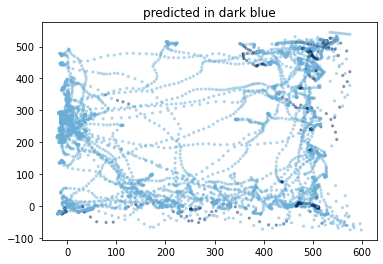

In [211]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=all_preds,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('predicted in dark blue')

Text(0.5, 1.0, 'ground truth in dark blue')

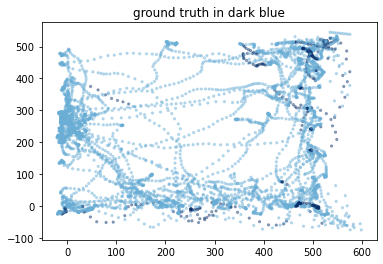

In [212]:
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([-1,1])
plt.title('ground truth in dark blue')

Text(0.5, 1.0, 'predicted in yellow, ground truth in cyan')

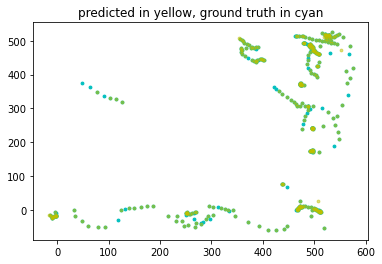

In [213]:
plt.scatter(aligned_df.nose.x[yVar==1],aligned_df.nose.y[yVar==1],s=8,c='c')
plt.scatter(aligned_df.nose.x[all_preds==1],aligned_df.nose.y[all_preds==1],c='y',s=8,alpha=0.5)
plt.title('predicted in yellow, ground truth in cyan')

In [196]:
# list features, their contribution
list(zip(X_train, clf.feature_importances_))

[('nose_ear_right', 0.08698120307662018),
 ('nose_ear_left', 0.08571484770100686),
 ('nose_paw_left_back', 0.11515330026909691),
 ('nose_paw_left_front', 0.03532464296088182),
 ('nose_paw_right_back', 0.09854245167538753),
 ('nose_paw_right_front', 0.08596267601617434),
 ('nose_tail_tip', 0.173231708714229),
 ('nose_tail_base', 0.12233163318854899),
 ('speed', 0.1967575363980544)]

In [198]:
from sklearn import tree

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[0])

Error in callback <function flush_figures at 0x000001A877BA3AF0> (for post_execute):



KeyboardInterrupt



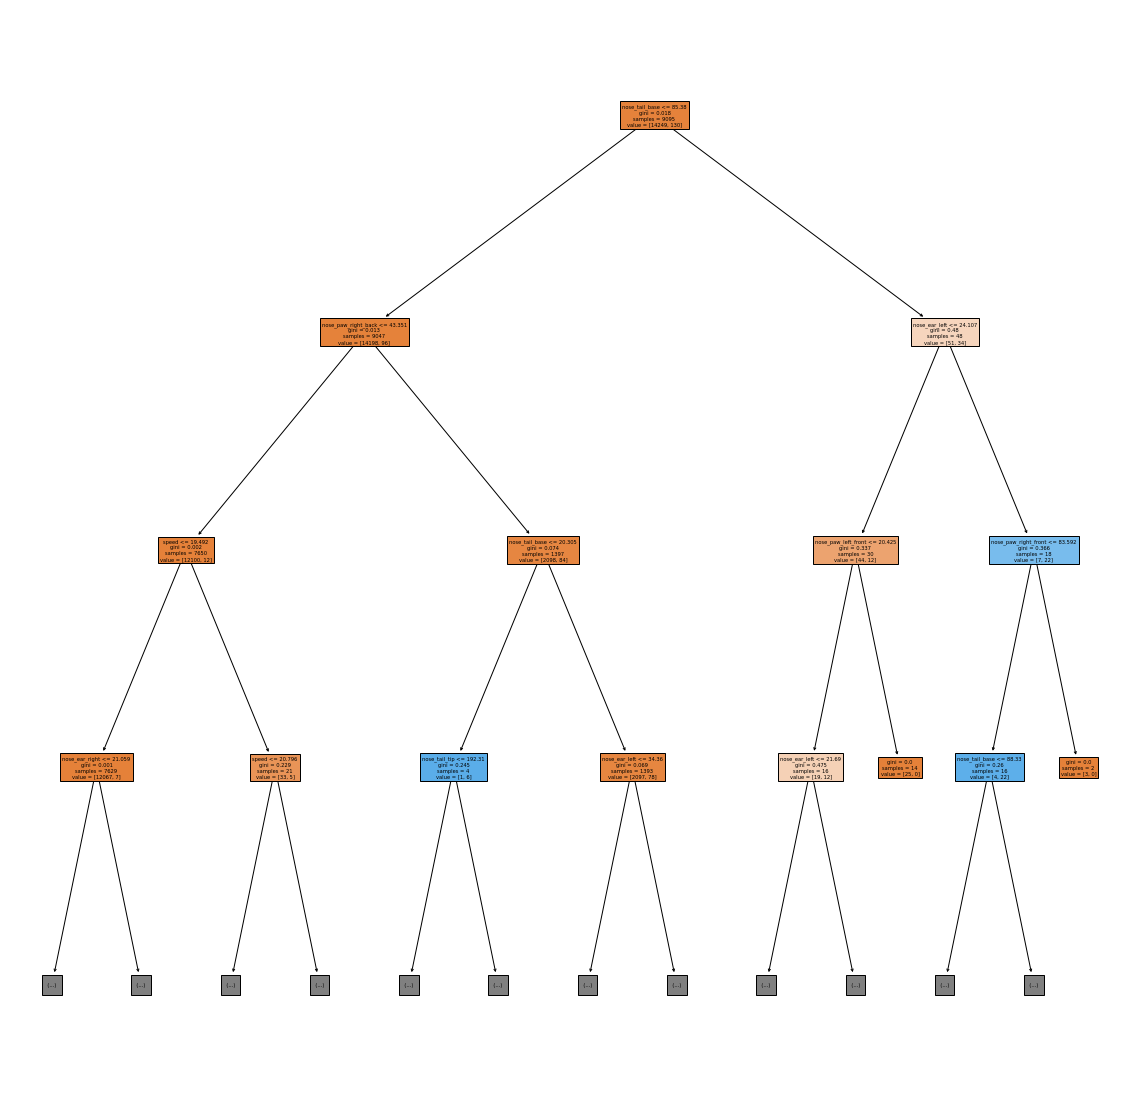

In [201]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[1], feature_names=X_train.columns, filled=True,max_depth=3)

# TODOs
- add classifier output to csv, save out
- add Alex to lab GitHub
- turn into scripts
- check additional ground truth data
- if looks good and Alex is happy, process all the videos
    - DLC analysis of video
    - run script on each output csv
    - send to Alex